In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
listings = pd.read_excel('arquivos_extraidos_tableau/listings_cleaned.xls')

In [3]:
listings.head()

,Access,Amenities,Bathrooms,Bed Type,Bedrooms,Beds,Cancellation Policy,City,Description,Distancia por range,...,Review Scores Accuracy,Review Scores Checkin,Review Scores Cleanliness,Review Scores Communication,Review Scores Location,Review Scores Rating,Review Scores Value,Security Deposit,Tempo de experiencia por ano,Weekly Price
0,I have an electronic keypad so arrival time ca...,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",1,Real Bed,1,2,strict,Boston,It's a 5 minute walk to Rosi Square to catch t...,Acima de 10 km,...,10.0,10.0,10.0,10.0,9.0,90.0,9.0,NaN,4,NaN
1,NaN,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,Real Bed,2,2,strict,Boston,This is a cozy and spacious two bedroom unit w...,Acima de 10 km,...,10.0,10.0,9.0,10.0,9.0,94.0,9.0,200.0,5,NaN
2,NaN,"{""Cable TV"",""Wireless Internet"",""Air Condition...",1,Real Bed,2,2,flexible,Boston,"Clean, sunny 2 bedroom in amazing Roslindale V...",5.01 km - 10 km,...,10.0,10.0,10.0,10.0,10.0,100.0,10.0,NaN,3,NaN
3,NaN,"{TV,Internet,""Wireless Internet"",""Air Conditio...",1,Real Bed,2,3,moderate,Boston,My place is close to Public Transportation. Th...,Acima de 10 km,...,10.0,10.0,10.0,10.0,9.0,97.0,10.0,NaN,1,NaN
4,NaN,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",1,Real Bed,3,5,flexible,Boston,Three bedroom in Boston's Roslindale neighborh...,Acima de 10 km,...,9.0,9.0,9.0,10.0,9.0,88.0,10.0,150.0,3,700.0


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 81 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Access                                               985 non-null    object        
 1   Amenities                                            1813 non-null   object        
 2   Bathrooms                                            1813 non-null   int64         
 3   Bed Type                                             1813 non-null   object        
 4   Bedrooms                                             1813 non-null   int64         
 5   Beds                                                 1813 non-null   int64         
 6   Cancellation Policy                                  1813 non-null   object        
 7   City                                                 1813 non-null   object        
 8 

## Análise de sensibilidade de Variações de Preços

### Média da taxa de ocupação anual por tipo de propriedade

#### Para a variação do preço abaixo, considerei uma relação inversa entre o preço e a ocupação (se o preço aumenta, a ocupação diminui, e vice-versa).

In [5]:
# Calcular a média da taxa de ocupação anual por tipo de propriedade (cenário base)
ocupacao_base = listings.groupby('Property Type')['annual_occupancy_rate'].mean()

# Definir as variações de preço: -30%, -20%, -10%, +10%, +20%, +30%
variacoes_preco = [-0.3, -0.2, -0.1, 0.1, 0.2, 0.3]

# Criar um DataFrame para armazenar os resultados de sensibilidade
resultados_sensibilidade = pd.DataFrame()

# Iterar sobre cada variação de preço
for variacao in variacoes_preco:
    # Criar um novo cenário com a variação de preço aplicada
    listings['Novo Preço'] = listings['Price'] * (1 + variacao)
    
    # Para simplificação, vamos supor que a variação de preço impacta a ocupação diretamente (essa relação pode ser ajustada)
    # Aqui vamos simular que um aumento de preço reduz a ocupação e uma redução de preço aumenta a ocupação
    listings['Nova Taxa de Ocupacao'] = np.where(variacao > 0, 
                                            listings['annual_occupancy_rate'] * (1 - variacao),
                                            listings['annual_occupancy_rate'] * (1 + abs(variacao)))
    
    # Calcular a nova média de ocupação por tipo de propriedade
    nova_ocupacao = listings.groupby('Property Type')['Nova Taxa de Ocupacao'].mean() * 100
    
    # Adicionar os resultados ao DataFrame de resultados de sensibilidade
    resultados_sensibilidade[f'Variação {variacao*100}%'] = nova_ocupacao

# Adicionar o cenário base para comparação
resultados_sensibilidade['Cenário Base'] = ocupacao_base * 100

# Exibir os resultados
print(round(resultados_sensibilidade,2))

               Variação -30.0%  Variação -20.0%  Variação -10.0%  \
Property Type                                                      
Apartment                66.68            61.55            56.42   
Condominium              82.42            76.08            69.74   
House                    58.59            54.08            49.57   

               Variação 10.0%  Variação 20.0%  Variação 30.0%  Cenário Base  
Property Type                                                                
Apartment               46.16           41.03           35.90         51.29  
Condominium             57.06           50.72           44.38         63.40  
House                   40.56           36.05           31.55         45.07  


## Análise de sensibilidade da influência da localização

Separei os bairros centrais e periféricos em duas listas. O código vai alternar entre eles automaticamente.
Simulação de preços: Para cada par de bairros, calcula-se a taxa de ocupação para diferentes faixas de preço (50 a 500).

In [17]:
# Definindo listas de bairros centrais e periféricos
central_neighborhoods =    ['Beacon Hill', 'Downtown', 'Fenway/Kenmore', 'North End', 'South Boston']
peripheral_neighborhoods = ['Dorchester', 'Hyde Park', 'Allston-Brighton', 'Charlestown', 'Mission Hill']

# Inicializar listas para armazenar as médias de taxa de ocupação
central_occupancy_avg = []
peripheral_occupancy_avg = []

# Definir a faixa de preços para simulação
Price_range = np.arange(100, 501, 50)  # Preços de 50 a 500

# Inicializar listas para armazenar as médias de taxa de ocupação
central_occupancy_avg = []
peripheral_occupancy_avg = []

# Iterar sobre os preços
for Price in Price_range:
    # Filtrar para cada bairro central e periférico com o preço máximo
    central_rates = []
    peripheral_rates = []
    
    # Coletar taxas de ocupação para bairros centrais
    for central_neighborhood in central_neighborhoods:
        central_data = listings[listings['Neighbourhood'] == central_neighborhood]
        central_rate = central_data[central_data['Price'] <= Price]['annual_occupancy_rate']
        if not central_rate.empty:
            central_rates.append(central_rate.mean())
    
    # Coletar taxas de ocupação para bairros periféricos
    for peripheral_neighborhood in peripheral_neighborhoods:
        peripheral_data = listings[listings['Neighbourhood'] == peripheral_neighborhood]
        peripheral_rate = peripheral_data[peripheral_data['Price'] <= Price]['annual_occupancy_rate']
        if not peripheral_rate.empty:
            peripheral_rates.append(peripheral_rate.mean())
    
    # Calcular a média das taxas de ocupação ignorando NaNs, mas verificando se há dados
    central_occupancy_avg.append(np.nanmean(central_rates) if central_rates else np.nan)
    peripheral_occupancy_avg.append(np.nanmean(peripheral_rates) if peripheral_rates else np.nan)

# Garantir que as listas são do mesmo comprimento
assert len(central_occupancy_avg) == len(peripheral_occupancy_avg) == len(Price_range), "As listas não têm o mesmo comprimento."

# Criar DataFrame para visualização
results_listings = pd.DataFrame({
    'Price': Price_range,
    'Central Average Occupancy Rate': central_occupancy_avg,
    'Peripheral Average Occupancy Rate': peripheral_occupancy_avg
})
    
# Imprimir os resultados
print("Análise de Sensibilidade: Influência da Localização na Taxa de Ocupação")
print("\nPreço\tTaxa de Ocupação Central\tTaxa de Ocupação Periférica")
for index, row in results_listings.iterrows():
    print(f"{row['Price']}\t{row['Central Average Occupancy Rate']:.2f}\t\t{row['Peripheral Average Occupancy Rate']:.2f}")

Análise de Sensibilidade: Influência da Localização na Taxa de Ocupação

Preço	Taxa de Ocupação Central	Taxa de Ocupação Periférica
100.0	0.58		0.75
150.0	0.52		0.63
200.0	0.59		0.61
250.0	0.55		0.60
300.0	0.55		0.59
350.0	0.54		0.59
400.0	0.56		0.58
450.0	0.56		0.58
500.0	0.55		0.58


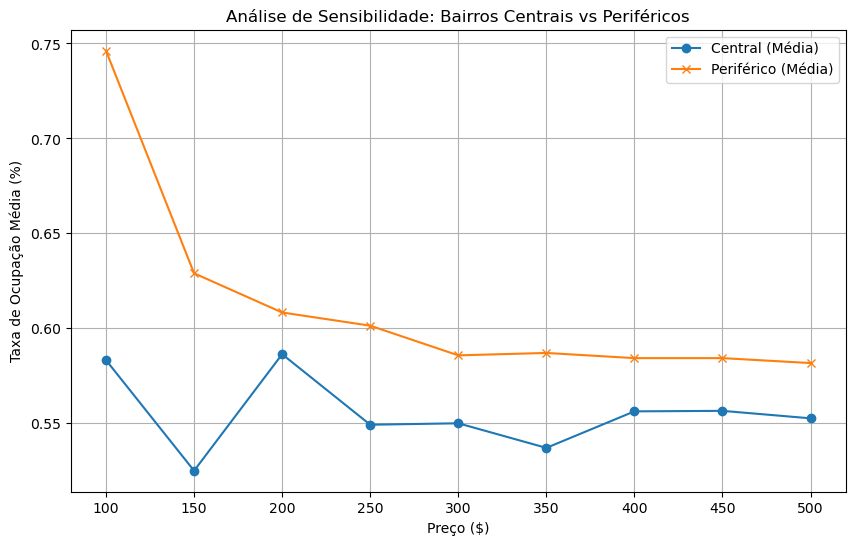

In [18]:
# Plotar o gráfico
plt.figure(figsize=(10,6))
plt.plot(results_listings['Price'], results_listings['Central Average Occupancy Rate'], label='Central (Média)', marker='o')
plt.plot(results_listings['Price'], results_listings['Peripheral Average Occupancy Rate'], label='Periférico (Média)', marker='x')

# Títulos e legendas
plt.title('Análise de Sensibilidade: Bairros Centrais vs Periféricos')
plt.xlabel('Preço ($)')
plt.ylabel('Taxa de Ocupação Média (%)')
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

À medida que o preço aumenta, a taxa de ocupação em bairros centrais não mostra uma tendência clara de recuperação, enquanto a taxa em bairros periféricos se mantém relativamente estável, sugerindo que imóveis em áreas periféricas podem ser percebidos como mais acessíveis ou atrativos.
A maior taxa de ocupação nos bairros periféricos pode indicar uma preferência por áreas menos centrais, possivelmente por serem mais acessíveis em termos de preço ou oferecerem um estilo de vida mais tranquilo.
As taxas de ocupação em bairros centrais tendem a flutuar mais, com uma taxa mais baixa de 0.52 a 150.0 e um leve aumento a 200.0. Em comparação, as taxas em bairros periféricos mostram uma leve diminuição, mas permanecem acima da taxa central em todos os pontos de preço.